<a href="https://colab.research.google.com/github/wakhunguadams/Bitcoin-price-forecasting/blob/main/btc_prediction_rnn_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

#ploting  libraries
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

This code will download Bitcoin data from Yahoo Finance starting from January 1, 2020, to April 10, 2024.
[You can download the data here](https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD)

In [ ]:
!pip install yfinance

import yfinance as yf

# Download Bitcoin data
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2024-04-10')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
btc_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


# **Data Fields Description**
**Date:** This column represents the date of the data point. It's the timestamp for when the data was recorded.

**Open:** This is the price of Bitcoin at the beginning of the trading day. It's the first price at which Bitcoin was traded during the day.

**High:** This is the highest price of Bitcoin reached during the trading day.

**Low:** This is the lowest price of Bitcoin reached during the trading day.

**Close:** This is the price of Bitcoin at the end of the trading day. It's the last price at which Bitcoin was traded during the day.

**Adj Close:** This is the adjusted closing price of Bitcoin. It accounts for any corporate actions, such as dividends or stock splits, that may affect the price. It's often used to calculate returns over time accurately.

**Volume:** This column represents the total number of Bitcoin tokens traded during the day.

In [ ]:
#see the number of days (rows) and fields available
btc_data.shape

(1560, 6)

In [ ]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1560 entries, 2020-01-01 to 2024-04-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1560 non-null   float64
 1   High       1560 non-null   float64
 2   Low        1560 non-null   float64
 3   Close      1560 non-null   float64
 4   Adj Close  1560 non-null   float64
 5   Volume     1560 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 85.3 KB


In [ ]:
btc_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1.560000e+03
mean,30494.712518,31193.703284,29759.890521,30533.322772,30533.322772,3.223368e+10
std,16169.715766,16600.321034,15695.736057,16188.787868,16188.787868,1.866381e+10
min,5002.578125,5331.833984,4106.980957,4970.788086,4970.788086,5.331173e+09
25%,17816.224121,18375.094727,17514.976562,17905.444824,17905.444824,2.011813e+10
50%,28439.460938,29007.070312,27980.690430,28438.839844,28438.839844,2.909820e+10
75%,42382.224609,43236.787109,41621.123047,42409.061523,42409.061523,3.938826e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11


In [ ]:
#check if there is any null values
btc_data.isnull().values.any()

False

# **Lets conduct some EDA**
we start by analyzing our first year 2020

In [ ]:
#slicing for jan 2020 to dec 2020
y_2020 = btc_data.loc['2020-01-01':'2020-12-31']

y_2020 = y_2020.drop(['Adj Close', 'Volume'], axis=1)


In [ ]:
y_2020.head()

,Open,High,Low,Close
Date,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383


In [ ]:
# Grouping by month and calculating the mean of 'Open' and 'Close'
monthwise = btc_data.groupby(btc_data.index.strftime('%B'))[['Open','Close']].mean()

# Specifying the desired order of months
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']

# Reindexing the DataFrame to match the desired order
monthwise = monthwise.reindex(new_order)

In [ ]:
monthwise

,Open,Close
Date,,
January,29458.772051,29487.134539
February,33671.230455,33916.660142
March,39139.085285,39330.920498
April,35895.998093,35852.259289
May,28951.756080,28727.962694
June,24463.902295,24370.316455
July,23819.274233,23907.899327
August,26896.710055,26895.119007
September,25706.045369,25677.740991


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparison between Stock open and close price')
fig.show()

In [ ]:
monthvise_low = btc_data.groupby(btc_data.index.strftime('%B'))['Low'].min()
monthvise_high = btc_data.groupby(btc_data.index.strftime('%B'))['High'].max()

monthvise_low = monthvise_low.reindex(new_order)
monthvise_high = monthvise_high.reindex(new_order)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title='Monthwise High and Low stock price for 2020')
fig.show()

In [ ]:
names = cycle(['Stock Open Price', 'Stock Close Price', 'Stock High Price', 'Stock Low Price'])

fig = px.line(btc_data, x=btc_data.index, y=[btc_data['Open'], btc_data['Close'], btc_data['High'], btc_data['Low']],
              labels={'Date': 'Date', 'value': 'Stock value'})
fig.update_layout(title='Stock analysis chart for 2020', font_size=15, font_color='black', legend_title='Stock Parameters')
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

Overal analysis 2020 -2024

In [ ]:
# Filter the btc_data DataFrame for 2020 to today
y_overall = btc_data.loc['2020-01-01':'2024-04-10']

# Drop 'Adj Close' and 'Volume' columns
y_overall = y_overall.drop(['Adj Close', 'Volume'], axis=1)

In [ ]:
monthvise = y_overall.groupby(y_overall.index.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order)


In [ ]:
monthwise

,Open,Close
Date,,
January,29458.772051,29487.134539
February,33671.230455,33916.660142
March,39139.085285,39330.920498
April,35895.998093,35852.259289
May,28951.756080,28727.962694
June,24463.902295,24370.316455
July,23819.274233,23907.899327
August,26896.710055,26895.119007
September,25706.045369,25677.740991


In [ ]:
names = cycle(['Stock Open Price', 'Stock Close Price', 'Stock High Price', 'Stock Low Price'])

fig = px.line(y_overall, x=y_overall.index, y=[y_overall['Open'], y_overall['Close'], y_overall['High'], y_overall['Low']],
              labels={'Date': 'Date', 'value': 'Stock value'})
fig.update_layout(title='Stock analysis chart', font_size=15, font_color='black', legend_title='Stock Parameters')
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

As we want to predict Close Price of the Bitcoin so we are just Considering Close aand Date

In [ ]:
# Let's first take all the Close Price
closedf = btc_data[['Close']]
print("Shape of close dataframe:", closedf.shape)


Shape of close dataframe: (1560, 1)


In [ ]:
fig = px.line(closedf, x=closedf.index, y=closedf['Close'], labels={'x': 'Date', 'y': 'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title='Whole period of timeframe of Bitcoin close price 2020-2024', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
#lets use one year for training
closedf = closedf[closedf.index > '2023-04-10']

# Create a copy of the filtered DataFrame
close_stock = closedf.copy()

# Print the total data for prediction
print("Total data for prediction:", closedf.shape[0])

Total data for prediction: 364


In [ ]:
fig = px.line(closedf, x=closedf.index, y=closedf['Close'], labels={'x': 'Date', 'y': 'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title='Considered period to predict Bitcoin close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
#normalizing the data
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape and scale the data
closedf_scaled = scaler.fit_transform(closedf.values.reshape(-1, 1))

print(closedf_scaled.shape)

(364, 1)


Slicing data into Training set and Testing set

In [ ]:
# Calculate the training and test sizes
training_size = int(len(closedf) * 0.60)
test_size = len(closedf) - training_size

# Split the data into training and testing sets
train_data = closedf.iloc[:training_size]#training size is the cutoff
test_data = closedf.iloc[training_size:]

print("train_data:", train_data.shape)
print("test_data:", test_data.shape)

train_data: (218, 1)
test_data: (146, 1)


In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]   ### i=0, 0,1,2,3, ..., 99
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15

X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (202, 15, 1)
y_train: (202, 1)
X_test: (130, 15, 1)
y_test: (130, 1)


In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (202, 15, 1)
X_test: (130, 15, 1)


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation="relu"))
model.add(Dense(1))

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)


Epoch 1/200
7/7 [==============================] - 2s 65ms/step - loss: 630440768.0000 - val_loss: 2043170944.0000
Epoch 2/200
7/7 [==============================] - 0s 17ms/step - loss: 595268992.0000 - val_loss: 1921331584.0000
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 557154688.0000 - val_loss: 1790327168.0000
Epoch 4/200
7/7 [==============================] - 0s 17ms/step - loss: 516173088.0000 - val_loss: 1648491136.0000
Epoch 5/200
7/7 [==============================] - 0s 18ms/step - loss: 472020448.0000 - val_loss: 1494310784.0000
Epoch 6/200
7/7 [==============================] - 0s 16ms/step - loss: 424048960.0000 - val_loss: 1327591552.0000
Epoch 7/200
7/7 [==============================] - 0s 15ms/step - loss: 371863744.0000 - val_loss: 1144055680.0000
Epoch 8/200
7/7 [==============================] - 0s 17ms/step - loss: 312763936.0000 - val_loss: 946001216.0000
Epoch 9/200
7/7 [==============================] - 0s 18ms/step - loss: 254152112

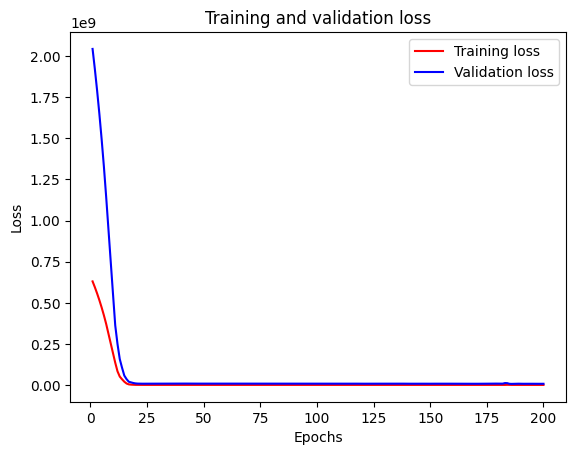

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)  # Adjusted to start from epoch 1

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')  # Added xlabel
plt.ylabel('Loss')  # Added ylabel
plt.legend(loc='best')  # Adjusted legend location
plt.show()


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape, test_predict.shape

5/5 [==============================] - 0s 4ms/step


((202, 1), (130, 1))

In [ ]:
# Transform back to the original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrics RMSE and MAE
print("Train data RMSE:", math.sqrt(mean_squared_error(original_ytrain, train_predict)))
print("Train data MSE:", mean_squared_error(original_ytrain, train_predict))
print("Train data MAE:", mean_absolute_error(original_ytrain, train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE:", math.sqrt(mean_squared_error(original_ytest, test_predict)))
print("Test data MSE:", mean_squared_error(original_ytest, test_predict))
print("Test data MAE:", mean_absolute_error(original_ytest, test_predict))

Train data RMSE: 53178476.063120596
Train data MSE: 2827950316395890.0
Train data MAE: 38613932.20728652
-------------------------------------------------------------------------------------
Test data RMSE: 136905919.3054607
Test data MSE: 1.874323074087331e+16
Test data MAE: 102013099.69382524


In [ ]:
# Evaluation metrics R2 score
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8369203792736494
Test data R2 score: 0.9350619788395307


In [ ]:
# Shift train predictions for plotting
look_back = time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict
print("Train predicted data:", trainPredictPlot.shape)

# Shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1:len(closedf)-1, :] = test_predict
print("Test predicted data:", testPredictPlot.shape)

# Generate cyclic names for the plot
names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])

# Create a DataFrame for plotting
plotdf = pd.DataFrame({
    'date': closedf.index,
    'original_close': closedf['Close'],
    'train_predicted_close': trainPredictPlot.reshape(1, -1)[0].tolist(),
    'test_predicted_close': testPredictPlot.reshape(1, -1)[0].tolist()
})

# Create the plot
fig = px.line(plotdf, x='date', y=['original_close', 'train_predicted_close', 'test_predicted_close'],
              labels={'value': 'Stock price', 'date': 'Date'})
fig.update_layout(title='Comparison between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(name=next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data: (364, 1)
Test predicted data: (364, 1)
